In [59]:
# plotting
import matplotlib.pyplot as plt

# image processing
import cv2

# opening files and paths
import os

# import utility functions
from shapely_conversion import convert
from shapely_utilities import *

# import spiral generation
import spiral as S
import fermat_spiral as FS

# optimization module
from optimization import optimization

import time

%reload_ext autoreload
%autoreload 2

In [2]:
'''
Plot a single path
'''
def plot_path(path, color=None):
    
    X = []
    Y = []

    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y,c=color)


'''
Plot a list of paths
'''
def plot_recursive_path(total_path, color=None):
    
    rest = []
    
    for path in total_path:
        if type(path) is list:
            plot_path(path, color)
            if path:
                pyplot.scatter(path[0][0], path[0][1], c='green')
                pyplot.scatter(path[-1][0], path[-1][1], c='red')
        else:
            rest.append(path)
            
    plot_path(rest, color)

In [69]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def generate_polygons(image, optimize=False, simplify=1):
    
    opt_reg=1
    opt_smh=10
    opt_spacing=1
            
    # create the polygons from the image
    polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE)
    
    formatted_polygons = []
    
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        '''
        Simplify the polygon first (all exterior and interiors)
        '''
        if optimize:
            
            optimize_time = time.time()
            s = list(sample(polygon.exterior,distance).coords)
            
            if len(s) > 5:
                ext = optimization(s, opt_reg, opt_smh, opt_spacing, False)

                ints = []

                for interior in polygon.interiors:
                    i = list(sample(interior,distance).coords)
            
                    if len(i) > 5:
                        ints.append(optimization(i, opt_reg, opt_smh, opt_spacing, False))

                polygon = Polygon(ext, holes=ints)

                print("\tOptimize:", time.time()-optimize_time)
                
                # simplify the shape to remove excess points
                polygon = polygon.simplify(simplify)

        else:
            polygon = polygon.simplify(simplify)
        
        formatted_polygons.append(polygon)
        
    return formatted_polygons

In [119]:
%%time
%matplotlib notebook
'''
This cell runs the complete pipeline from image to CFS output
'''

# distance in between each contour
distance = 5

# filename of image to process
filename = 'files/oval.png'

# image should be in binary format
image = cv2.imread(filename,0)

print(not image is None)

polygons = generate_polygons(image, True, simplify=1)

True
	Optimize: 0.04540705680847168
CPU times: user 48.8 ms, sys: 23.3 ms, total: 72.1 ms
Wall time: 60.7 ms


In [120]:
%%time

results = FS.execute(polygons, distance, connected=True)

1 1.000678572701133
CPU times: user 248 ms, sys: 0 ns, total: 248 ms
Wall time: 248 ms


<IPython.core.display.Javascript object>


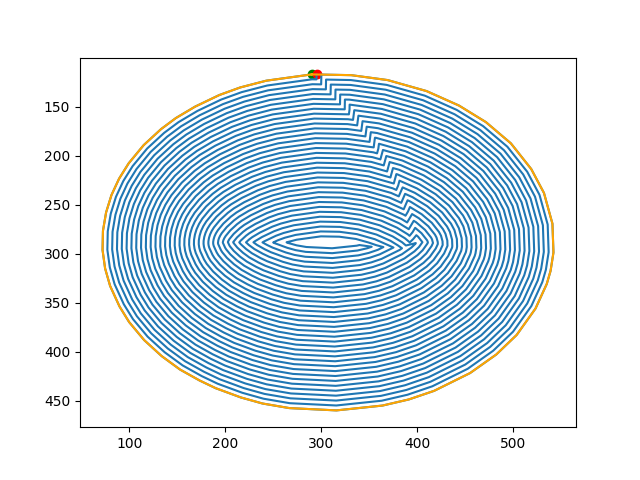

In [121]:
plot_recursive_path(results)
plt.gca().invert_yaxis()

In [122]:
plot_path(polygons[0].exterior.coords, color='orange')

In [123]:
from metrics import Metrics

measurer = Metrics(segments=True, commands=True, curvature=False, underfill=True)

1
1 1.0002249400533483


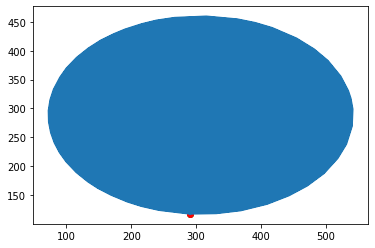

2
1 1.0003140133139008


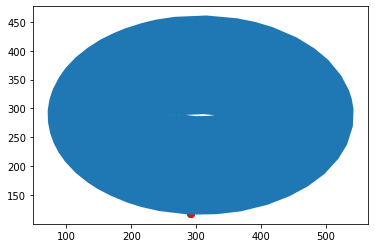

3
1 1.0005630324255468


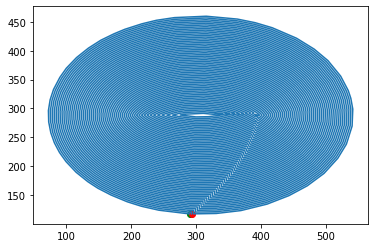

4
1 1.0008827823916755


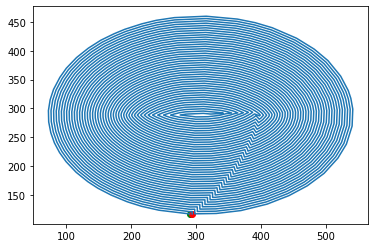

5
1 1.000678572701133


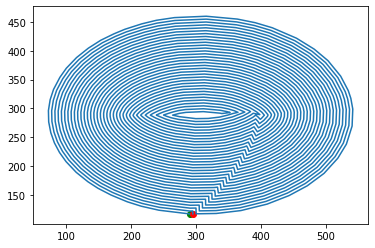

6
1 1.0006291858194514


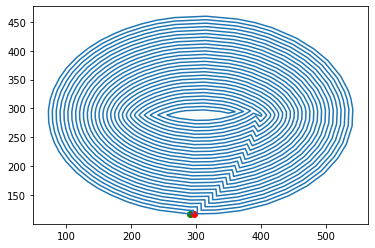

7
1 1.0005249794642084


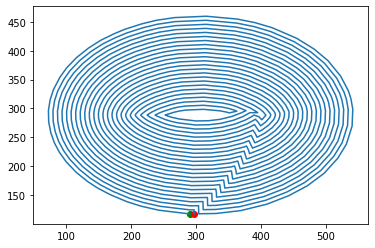

8
1 1.0009039215212008


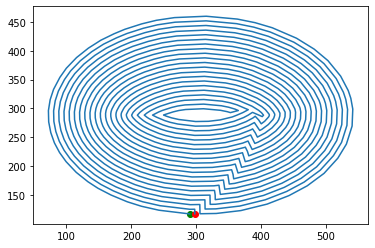

9
1 1.0014238868003214


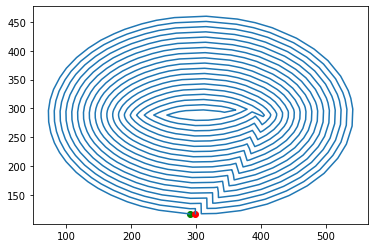

In [135]:
'''
Test different fills
'''

%matplotlib inline

metrics = []

for i in range(1,10):
    print(i)
    results = FS.execute(polygons, i, connected=True)
    plot_recursive_path(results)
    pyplot.show()
    metrics.append(measurer.measure(results, "CFS", i, polygons))

In [137]:
import pandas as pd


data = pd.DataFrame(metrics)

data

,Method,Distance,Segments,Commands,Curvature,Underfill,Overfill
0,CFS,1,1,7341,NaN,0.000325,NaN
1,CFS,2,1,3667,NaN,0.001364,NaN
2,CFS,3,1,2448,NaN,0.001214,NaN
3,CFS,4,1,1841,NaN,0.001150,NaN
4,CFS,5,1,1467,NaN,0.003350,NaN
5,CFS,6,1,1220,NaN,0.006513,NaN
6,CFS,7,1,1045,NaN,0.007484,NaN
7,CFS,8,1,913,NaN,0.008248,NaN
8,CFS,9,1,815,NaN,0.005128,NaN


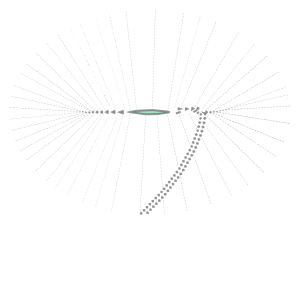

In [132]:
'''
Display the underfill areas (sanity check)
'''

from shapely.geometry import MultiPolygon

path_areas = [LineString(path).buffer(distance/2+0.001) for path in results]
MultiPolygon(polygons).difference(MultiPolygon(path_areas))

In [112]:
MultiPolygon(path_areas).difference(MultiPolygon(polygons))

In [43]:
# helper function to display the format of the "result" tree
# - the "result" tree is the representation of the distance transform 
# - EX: A tree of "['X','X','X', ['X',['X','X'], ['X']], ['X']]" has...
# 1. Three successive outer contours (no branches)
# 2. A branch with a single contour with a depth-2 branch and a depth-1 branch
# 3. A branch with a single contour

# TODO there is probably a better way to set up the trees in this scenario
def simplify_tree(result):
    
    root = []
    output = []
    for b in result:
        if type(b) is list:
            
            if not b:
                print("EMPTY!")
            output.append(simplify_tree(b))
            
    return ["X"] + output

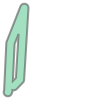

In [80]:
p = LineString(results[0]).buffer(distance/2)
p

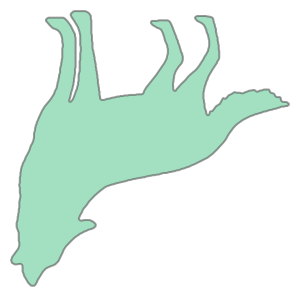

In [84]:
from shapely.geometry import MultiPolygon
MultiPolygon(polygons)

In [ ]:
from gcode import GcodeWriter

In [ ]:
gc = GcodeWriter(filename='wolf.gcode', scale = 0.1)

gc.convert([results])

In [ ]:
def remove_short_paths(temp_path, length=20):
    
    clean_path = []
    
    for path in temp_path:
        
        if LineString(path).length > length:
            clean_path.append(path)
    
    return clean_path